# Step 1 — ClinVar GRCh38 Data Setup

**Goal:** Download the current ClinVar GRCh38 VCF, filter to high-confidence Pathogenic/Benign variants, and produce a clean, stratified sample of ~5,000 variants ready for AlphaGenome scoring.

**Output:** `clinvar_filtered.parquet` — columns: `[CHROM, POS, REF, ALT, CLINSIG, CLNREVSTAT, GENEINFO, MC, variant_id]`

**Design decisions:**
- Use **strict** labels only: `Pathogenic` and `Benign` (exclude Likely_pathogenic, Likely_benign, VUS)
- Gate on `CLNREVSTAT` to keep only variants with at least one submitter providing criteria — reduces label noise
- Oversample splice/regulatory variants for Objective 1 (functional disruption), then pad with random variants to reach target N
- Keep only SNVs and small indels (≤50 bp) — AlphaGenome handles these; large SVs are out of scope

## Cell 1 — Install dependencies

In [1]:
!pip install "matplotlib>=3.9" "numpy>=2.0" pyarrow --upgrade --quiet
print("Installs complete")

Installs complete


## Cell 2 — Imports and configuration

In [3]:
import os
import re
import gzip
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ── Configuration ──────────────────────────────────────────────────────────────

CLINVAR_URL   = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"
CLINVAR_LOCAL = Path("clinvar.vcf.gz")
# Strict labels only — no Likely_* or VUS
KEEP_CLINSIG = {"Pathogenic", "Benign"}

# Minimum review tier 2 (at least one submitter with criteria)
ACCEPTABLE_REVSTAT = {
    "criteria_provided,_single_submitter",
    "criteria_provided,_multiple_submitters,_no_conflicts",
    "reviewed_by_expert_panel",
    "practice_guideline",
}

# SO terms for splice/regulatory variants — priority oversampled for Objective 1
SPLICE_REGULATORY_SO = {
    "SO:0001575",  # splice_donor_variant
    "SO:0001574",  # splice_acceptor_variant
    "SO:0001630",  # splice_region_variant
    "SO:0001619",  # non_coding_transcript_variant
    "SO:0001631",  # upstream_gene_variant
    "SO:0001632",  # downstream_gene_variant
    "SO:0001623",  # 5_prime_UTR_variant
    "SO:0001624",  # 3_prime_UTR_variant
    "SO:0001583",  # missense_variant
}

TARGET_N      = 5000   # total variants in final sample
SPLICE_FRAC   = 0.40   # 40% splice/regulatory per class
BALANCE_RATIO = 1.0    # 1:1 Pathogenic:Benign
RANDOM_SEED   = 42
MAX_INDEL_LEN = 50     # exclude indels longer than this

rng = np.random.default_rng(RANDOM_SEED)
print("Imports and config ready ✓")

Imports and config ready ✓


## Cell 3 — Download ClinVar VCF (with caching)

In [5]:
def download_with_progress(url: str, dest: Path) -> None:
    """Download a file with a simple progress indicator."""
    def _hook(count, block_size, total_size):
        if total_size > 0:
            pct = count * block_size / total_size * 100
            print(f"\r  {min(pct, 100):.1f}%", end="", flush=True)

    print(f"Downloading {url.split('/')[-1]} ...")
    urllib.request.urlretrieve(url, dest, reporthook=_hook)
    print(f"\n  Saved to {dest} ({dest.stat().st_size / 1e6:.1f} MB)")


# Use the stable 'latest' URL — versioned snapshot gets rotated out weekly
CLINVAR_URL   = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"
CLINVAR_LOCAL = Path("clinvar.vcf.gz")  # update local filename to match

if not CLINVAR_LOCAL.exists():
    download_with_progress(CLINVAR_URL, CLINVAR_LOCAL)
else:
    print(f"Using cached file: {CLINVAR_LOCAL} ({CLINVAR_LOCAL.stat().st_size / 1e6:.1f} MB)")

  100.0%
  Saved to clinvar.vcf.gz (189.0 MB)


## Cell 4 — Parse VCF and apply filters

In [9]:
# ── Helper functions ───────────────────────────────────────────────────────────

def parse_clnsig(raw: str) -> str | None:
    """
    Extract primary clinical significance label.
    CLNSIG can be pipe/slash-delimited — take the first token only.
    Returns None if not in KEEP_CLINSIG (Pathogenic or Benign).
    """
    if raw is None:
        return None
    primary = raw.split("|")[0].split("/")[0].strip()
    return primary if primary in KEEP_CLINSIG else None


def parse_mc(raw: str | None) -> str:
    """
    Extract SO term IDs from MC (molecular consequence) INFO field.
    Format: 'SO:0001575|splice_donor_variant,SO:0001583|missense_variant'
    Returns comma-joined SO IDs, or '' if absent.
    """
    if raw is None:
        return ""
    return ",".join(re.findall(r"SO:\d+", raw))


def is_splice_regulatory(mc_str: str) -> bool:
    """True if any MC SO term matches our splice/regulatory priority set."""
    return bool(set(mc_str.split(",")) & SPLICE_REGULATORY_SO)


def is_small_variant(ref: str, alt: str) -> bool:
    """Exclude large indels/SVs above MAX_INDEL_LEN threshold."""
    return max(len(ref), len(alt)) <= MAX_INDEL_LEN


def parse_info_field(info_str: str) -> dict:
    """
    Parse VCF INFO column string into a dict.
    Handles flag fields (no '=') and key=value fields.
    """
    result = {}
    for part in info_str.split(";"):
        if "=" in part:
            k, v = part.split("=", 1)
            result[k] = v
        else:
            result[part] = True
    return result


# ── Parse loop ────────────────────────────────────────────────────────────────

records = []
n_total = n_clinsig_fail = n_revstat_fail = n_size_fail = 0

print("Parsing VCF (pure Python gzip) ...")

with gzip.open(CLINVAR_LOCAL, "rt", encoding="utf-8") as fh:
    for line in fh:

        if line.startswith("#"):
            continue

        n_total += 1
        if n_total % 200_000 == 0:
            print(f"  Processed {n_total:,} variants, kept {len(records):,} ...")

        cols = line.rstrip("\n").split("\t")
        if len(cols) < 8:
            continue

        chrom, pos, _, ref, alt_col, _, _, info_str = cols[:8]
        alt = alt_col.split(",")[0]
        info = parse_info_field(info_str)

        # Filter 1: clinical significance
        clinsig = parse_clnsig(info.get("CLNSIG"))
        if clinsig is None:
            n_clinsig_fail += 1
            continue

        # Filter 2: review status quality gate
        revstat_key = info.get("CLNREVSTAT", "").replace("%2C", ",")
        if revstat_key not in ACCEPTABLE_REVSTAT:
            n_revstat_fail += 1
            continue

        # Filter 3: variant size
        if not is_small_variant(ref, alt):
            n_size_fail += 1
            continue

        mc_str = parse_mc(info.get("MC"))
        gene   = info.get("GENEINFO", "")

        if not chrom.startswith("chr"):
            chrom = "chr" + chrom

        records.append({
            "CHROM"        : chrom,
            "POS"          : int(pos),
            "REF"          : ref,
            "ALT"          : alt,
            "CLINSIG"      : clinsig,
            "CLNREVSTAT"   : revstat_key,
            "GENEINFO"     : gene,
            "MC"           : mc_str,
            "is_splice_reg": is_splice_regulatory(mc_str),
        })

df_all = pd.DataFrame(records)

print(f"\n── Parse summary ──")
print(f"  Total variants in VCF : {n_total:>10,}")
print(f"  Failed CLNSIG filter  : {n_clinsig_fail:>10,}")
print(f"  Failed REVSTAT filter : {n_revstat_fail:>10,}")
print(f"  Failed size filter    : {n_size_fail:>10,}")
print(f"  Passed all filters    : {len(df_all):>10,}")
print(f"\nClass distribution:")
print(df_all["CLINSIG"].value_counts())

Parsing VCF (pure Python gzip) ...
  Processed 200,000 variants, kept 17,915 ...
  Processed 400,000 variants, kept 36,838 ...
  Processed 600,000 variants, kept 58,267 ...
  Processed 800,000 variants, kept 79,187 ...
  Processed 1,000,000 variants, kept 97,957 ...
  Processed 1,200,000 variants, kept 117,224 ...
  Processed 1,400,000 variants, kept 139,981 ...
  Processed 1,600,000 variants, kept 160,907 ...
  Processed 1,800,000 variants, kept 181,538 ...
  Processed 2,000,000 variants, kept 201,555 ...
  Processed 2,200,000 variants, kept 222,290 ...
  Processed 2,400,000 variants, kept 241,912 ...
  Processed 2,600,000 variants, kept 264,106 ...
  Processed 2,800,000 variants, kept 289,999 ...
  Processed 3,000,000 variants, kept 308,299 ...
  Processed 3,200,000 variants, kept 331,473 ...
  Processed 3,400,000 variants, kept 352,521 ...
  Processed 3,600,000 variants, kept 379,895 ...
  Processed 3,800,000 variants, kept 399,562 ...
  Processed 4,000,000 variants, kept 414,659 ..

## Cell 5 — Stratified downsampling to ~5,000 variants

In [13]:
def stratified_sample(
    df: pd.DataFrame,
    target_n: int,
    splice_frac: float,
    seed: int,
) -> pd.DataFrame:
    """
    Build a balanced, stratified sample of `target_n` variants.

    Strategy:
    - 50% Pathogenic, 50% Benign (balanced binary classification)
    - Within each class: `splice_frac` from splice/regulatory variants,
      remainder from the general pool
    - Prioritises splice/regulatory because Objective 1 (functional disruption)
      specifically targets splicing/expression signal
    """
    n_per_class = target_n // 2
    n_splice    = int(n_per_class * splice_frac)
    n_general   = n_per_class - n_splice

    sampled_parts = []

    for label in ["Pathogenic", "Benign"]:
        subset  = df[df["CLINSIG"] == label]
        splice  = subset[subset["is_splice_reg"]]
        general = subset[~subset["is_splice_reg"]]

        # Sample splice/regulatory (up to available count)
        n_s      = min(n_splice, len(splice))
        s_sample = splice.sample(n=n_s, random_state=seed) if n_s > 0 else pd.DataFrame()

        # Fill remaining slots from general pool
        # If splice pool was short, extra slots go to general
        n_g      = min(n_per_class - n_s, len(general))
        g_sample = general.sample(n=n_g, random_state=seed) if n_g > 0 else pd.DataFrame()

        combined = pd.concat([s_sample, g_sample], ignore_index=True)
        sampled_parts.append(combined)
        print(f"  {label}: {len(combined):,} variants "
              f"({n_s} splice/reg + {n_g} general)")

    result = pd.concat(sampled_parts, ignore_index=True)
    result = result.sample(frac=1, random_state=seed).reset_index(drop=True)  # shuffle
    return result


print(f"Sampling {TARGET_N:,} variants (balanced, splice-enriched) ...")
df_sample = stratified_sample(df_all, TARGET_N, SPLICE_FRAC, RANDOM_SEED)

# Stable unique variant_id — exact format AlphaGenome batch scorer expects
df_sample["variant_id"] = (
    df_sample["CHROM"] + "_"
    + df_sample["POS"].astype(str) + "_"
    + df_sample["REF"] + "_"
    + df_sample["ALT"] + "_b38"
)

print(f"\nFinal sample: {len(df_sample):,} variants")
print(df_sample["CLINSIG"].value_counts())
print(f"\nSplice/regulatory fraction: "
      f"{df_sample['is_splice_reg'].mean():.1%}")

Sampling 5,000 variants (balanced, splice-enriched) ...
  Pathogenic: 2,500 variants (1000 splice/reg + 1500 general)
  Benign: 2,500 variants (1000 splice/reg + 1500 general)

Final sample: 5,000 variants
CLINSIG
Pathogenic    2500
Benign        2500
Name: count, dtype: int64

Splice/regulatory fraction: 40.0%


## Cell 6 — Sanity checks

In [17]:
# ── Check 1: no duplicate variant IDs ─────────────────────────────────────────
n_dupes = df_sample["variant_id"].duplicated().sum()
print(f"Duplicate variant_ids: {n_dupes}")
assert n_dupes == 0, "Duplicate variant_ids found — check parsing logic"

# ── Check 2: all chromosomes are canonical (chr1–22, chrX, chrY) ──────────────
canonical = {f"chr{i}" for i in range(1, 23)} | {"chrX", "chrY"}
non_canonical = set(df_sample["CHROM"]) - canonical
print(f"Non-canonical chroms: {non_canonical}")
before = len(df_sample)
df_sample = df_sample[df_sample["CHROM"].isin(canonical)].reset_index(drop=True)
print(f"Removed {before - len(df_sample)} variants on non-canonical contigs")

# ── Check 3: filter missing REF/ALT (don't assert — ClinVar has legitimate '.' ──
# and '*' spanning deletion alleles that we simply drop)
before = len(df_sample)
df_sample = df_sample[
    ~df_sample[["REF", "ALT"]].isin(["", None, ".", "*"]).any(axis=1)
].reset_index(drop=True)
print(f"Removed {before - len(df_sample)} variants with missing/placeholder alleles")

# ── Check 4: all bases are ACGT (no ambiguous IUPAC codes) ────────────────────
before = len(df_sample)
df_sample = df_sample[
    df_sample["REF"].str.match(r'^[ACGTacgt]+$') &
    df_sample["ALT"].str.match(r'^[ACGTacgt]+$')
].reset_index(drop=True)
print(f"Removed {before - len(df_sample)} variants with non-ACGT alleles")

print(f"\nFinal clean sample: {len(df_sample):,} variants")
print(df_sample["CLINSIG"].value_counts())
print(df_sample[["CHROM", "POS", "REF", "ALT", "CLINSIG", "variant_id"]].head(5))

Duplicate variant_ids: 0
Non-canonical chroms: set()
Removed 0 variants on non-canonical contigs
Removed 3 variants with missing/placeholder alleles
Removed 0 variants with non-ACGT alleles

Final clean sample: 4,989 variants
CLINSIG
Pathogenic    2500
Benign        2489
Name: count, dtype: int64
   CHROM        POS  REF ALT     CLINSIG                variant_id
0  chr17   44378668  GCA   G  Pathogenic  chr17_44378668_GCA_G_b38
1   chr9  120989595   GC  TT      Benign  chr9_120989595_GC_TT_b38
2   chr5    7900706    C   A      Benign      chr5_7900706_C_A_b38
3  chr18   33738875    C   T  Pathogenic    chr18_33738875_C_T_b38
4   chr2   47798724    A  AC  Pathogenic    chr2_47798724_A_AC_b38


## Cell 7 — Exploratory visualisations

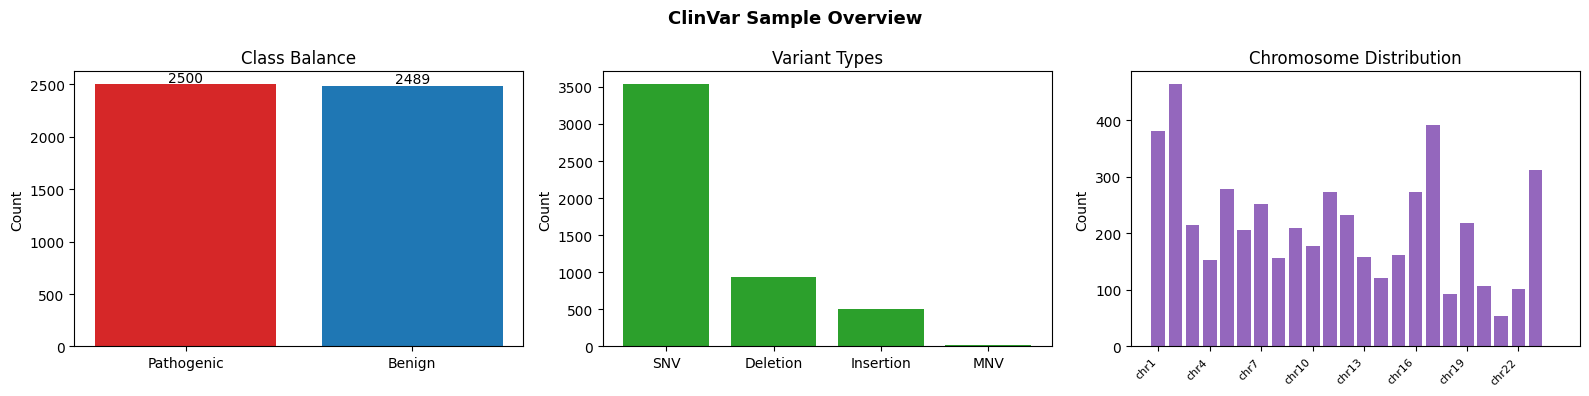


Splice/regulatory variant breakdown by class:
is_splice_reg  False  True 
CLINSIG                    
Benign         0.599  0.401
Pathogenic     0.600  0.400


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("ClinVar Sample Overview", fontsize=13, fontweight="bold")

# ── Panel 1: class balance ─────────────────────────────────────────────────────
counts = df_sample["CLINSIG"].value_counts()
axes[0].bar(counts.index, counts.values, color=["#d62728", "#1f77b4"])
axes[0].set_title("Class Balance")
axes[0].set_ylabel("Count")
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, str(v), ha="center", fontsize=10)

# ── Panel 2: variant type distribution ────────────────────────────────────────
def classify_variant(row):
    """SNV if single base change; otherwise small indel."""
    if len(row.REF) == 1 and len(row.ALT) == 1:
        return "SNV"
    elif len(row.REF) > len(row.ALT):
        return "Deletion"
    elif len(row.REF) < len(row.ALT):
        return "Insertion"
    else:
        return "MNV"

df_sample["var_type"] = df_sample.apply(classify_variant, axis=1)
type_counts = df_sample["var_type"].value_counts()
axes[1].bar(type_counts.index, type_counts.values, color="#2ca02c")
axes[1].set_title("Variant Types")
axes[1].set_ylabel("Count")

# ── Panel 3: chromosome distribution ──────────────────────────────────────────
chrom_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
chrom_counts = df_sample["CHROM"].value_counts().reindex(chrom_order, fill_value=0)
axes[2].bar(range(len(chrom_order)), chrom_counts.values, color="#9467bd")
axes[2].set_xticks(range(0, len(chrom_order), 3))
axes[2].set_xticklabels(chrom_order[::3], rotation=45, ha="right", fontsize=8)
axes[2].set_title("Chromosome Distribution")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.savefig("clinvar_sample_overview.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Splice/regulatory breakdown by class ─────────────────────────────────────
print("\nSplice/regulatory variant breakdown by class:")
print(
    df_sample.groupby("CLINSIG")["is_splice_reg"]
    .value_counts(normalize=True)
    .unstack()
    .round(3)
)

## Cell 8 — Save outputs

In [21]:
# ── Primary output: full annotated sample (parquet for efficient I/O) ─────────
out_parquet = "clinvar_filtered.parquet"
df_sample.to_parquet(out_parquet, index=False)
print(f"Saved full annotated sample → {out_parquet}")

# ── AlphaGenome-ready TSV (exact format expected by batch variant scorer) ──────
# Column order matches AlphaGenome's VCF input specification exactly
out_vcf_tsv = "clinvar_alphagenome_input.tsv"
df_sample[["variant_id", "CHROM", "POS", "REF", "ALT"]].to_csv(
    out_vcf_tsv, sep="\t", index=False
)
print(f"Saved AlphaGenome input TSV → {out_vcf_tsv}")

# ── Quick preview of final clean dataframe ────────────────────────────────────
print(f"\nFinal dataframe shape: {df_sample.shape}")
print(f"Columns: {df_sample.columns.tolist()}")
df_sample[["CHROM", "POS", "REF", "ALT", "CLINSIG"]].head(10)

Saved full annotated sample → clinvar_filtered.parquet
Saved AlphaGenome input TSV → clinvar_alphagenome_input.tsv

Final dataframe shape: (4989, 11)
Columns: ['CHROM', 'POS', 'REF', 'ALT', 'CLINSIG', 'CLNREVSTAT', 'GENEINFO', 'MC', 'is_splice_reg', 'variant_id', 'var_type']


,CHROM,POS,REF,ALT,CLINSIG
0,chr17,44378668,GCA,G,Pathogenic
1,chr9,120989595,GC,TT,Benign
2,chr5,7900706,C,A,Benign
3,chr18,33738875,C,T,Pathogenic
4,chr2,47798724,A,AC,Pathogenic
5,chr20,3916927,CT,C,Pathogenic
6,chr6,63721134,TTAATG,T,Pathogenic
7,chr18,23928156,C,A,Pathogenic
8,chr13,32355076,CA,C,Pathogenic
9,chrX,31679566,AC,A,Pathogenic


## Summary

| Output file | Contents | Used in |
|---|---|---|
| `clinvar_filtered.parquet` | Full annotated 5K sample with all metadata | Steps 3–5 |
| `clinvar_alphagenome_input.tsv` | Minimal TSV for AlphaGenome batch scorer | Step 2 |
| `clinvar_sample_overview.png` | Class/type/chrom distribution plots | QC |